# Predict Intervention Responsiveness

In [1]:
import os
import csv
import json
import pickle

# Data manipulation and analysis
import pandas as pd
import numpy as np
import time


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
from collections import defaultdict
from scipy.stats import norm

# Machine Learning and preprocessing
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, auc, f1_score, 
    silhouette_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LassoCV, ElasticNetCV

# Advanced machine learning models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Statistical analysis
from scipy.stats import (
    pearsonr, spearmanr, kendalltau, ttest_ind, mannwhitneyu, ttest_rel, wilcoxon
)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Utilities
from itertools import combinations, chain
from tqdm import tqdm

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, precision_score, 
                                recall_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, 
                                precision_recall_curve, auc)
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import os


## Pre-Processing

### Define threshold for responsiveness

Indicate change threshold that qualifies a participant as responsive vs non-responsive

In [2]:
# DEFINE RESPONSIVENESS

# avg reduction in drinking occasions between active and control weeks
def_response_drink_occasions = -2

### Load data

In [3]:
output_dir = "../../results"

data_study1 = pd.read_csv('../../SHINE/osf_study1.csv')
data_study2 = pd.read_csv('../../SHINE/osf_study2.csv')

merged_brain_behav = pd.read_csv('../../SHINE/demographics/merged_brain_behav.csv')
data_buckets_mj = pd.read_csv('../../SHINE/intervention_df_subset_011222mj.csv', index_col=0)
muri_baseline_scored = pd.read_csv('../../SHINE/qualtrics/1_baseline/muri_baseline_scored.csv')

social_network_centralities = pd.read_csv('../../SHINE/Networks/network_centralities.csv')
added_vars_df = pd.read_csv('../../SHINE/EMA_Round1/Yoona_PurposeAnalysis/data/old/baseline_survey.csv')

b1_alcohol_self = pd.read_csv('../../SHINE/final_buckets/alcoholself_bucket280225.csv', index_col=0)
b2_group_subjective = pd.read_csv('../../SHINE/final_buckets/subjective_grouperceptions_280225.csv', index_col=0)
b2_group_subjective_old = pd.read_csv('/Users/fmagdalena/Documents/GitHub/shine-network-analysis/SHINE/b2_group_subjective_new.csv')
b3_group_sociometric = pd.read_csv('../../src/responsiveness/data_social.csv')
b4_brain = pd.read_csv('../../SHINE/final_buckets/brain_bucket_280225.csv', index_col=0)
b5_demographic = pd.read_csv('../../SHINE/final_buckets/demographic_bucket280225.csv', index_col=0)
b6_psychometric = pd.read_csv('../../SHINE/final_buckets/psychometrics_bucket280225.csv', index_col=0)

b2_group_subjective_test = pd.read_csv('/Users/fmagdalena/Documents/GitHub/shine-network-analysis/SHINE/final_buckets/subjective_grouperceptions_test.csv')
b2_group_subjective_test_study1 = pd.read_csv('/Users/fmagdalena/Documents/GitHub/shine-network-analysis/SHINE/final_buckets/subjective_grouperceptions_test_study1.csv')


print(b2_group_subjective.columns)
print(added_vars_df)

# b4_brain = pd.merge(data_buckets_mj.iloc[1:].loc[:, ['SHINEID', 'segregation_resting_state_total']], b4_brain, left_on='SHINEID', right_on='id', how='inner').drop(columns=['SHINEID'])

Index(['avg_alcmost_freq', 'avg_alcmost', 'alc_norm_5_r', 'groupAtt_alc',
       'groupAtt_binge'],
      dtype='object')
     Unnamed: 0       pID groupID       group_type group_gender  \
0             1   muri012     g2p           sports            M   
1             2   muri016     g2p           sports            M   
2             3   muri017     g2p           sports            M   
3             4   muri018     g2p           sports            M   
4             5   muri020     g2p           sports            M   
..          ...       ...     ...              ...          ...   
651         652  muric530    g10c  performing_arts           MF   
652         653  muric531    g10c  performing_arts           MF   
653         654  muric532    g10c  performing_arts           MF   
654         655  muric533    g10c  performing_arts           MF   
655         656  muric534    g10c  performing_arts           MF   

     baseline_partial_n  baseline_socnet_n  baseline_complete_n  group_si

In [4]:
b2_group_subjective.isna().sum()
# b2_group_subjective.drop(columns=['pID', 'X', 'alc_norm_5'], inplace=True)

b2_group_subjective.head()
b2_group_subjective.isna().sum()

avg_alcmost_freq    0
avg_alcmost         0
alc_norm_5_r        0
groupAtt_alc        0
groupAtt_binge      0
dtype: int64

In [5]:
b1_alcohol_self.columns

Index(['id', 'alc_binge_efficacy', 'alc_intent_binge',
       'DMQ_drinking_coping_motive', 'DMQ_drinking_enhancement_motive',
       'DMQ_drinking_social_motive', 'DMQ_drinking_conformity_motive',
       'AUQ_drink_intent', 'AUQ_drink_frequency', 'AUQ_drink_amount',
       'alcohol_alc_att_1', 'alcohol_alc_att_2', 'DEQ_reduced_tension_exp',
       'DEQ_increased_confidence_exp', 'DEQ_negative_consequences_exp',
       'DEQ_reduced_cognition_exp', 'DEQ_increased_sexual_exp'],
      dtype='object')

In [6]:
# b1_alcohol_self.columns
# b1_alcohol_self = b1_alcohol_self.drop(columns=[col for col in b1_alcohol_self.columns if 'DEQ' in col])
# b1_alcohol_self.columns

In [7]:
b2_group_subjective_old.isna().sum()

id                  0
groupAtt_alc        0
groupAtt_binge      0
avg_alcmost_freq    0
avg_alcmost         0
dtype: int64

In [8]:
b6_psychometric.isna().sum()
b6_psychometric = b6_psychometric[b6_psychometric['id'] != 'muri196']
b6_psychometric = b6_psychometric[b6_psychometric['id'] != 'muri086']

In [9]:
b6_psychometric.head(50)

,id,STAI_mean,ACS_attentionshifting,ACS_focus,ACS_mean,CESD_mean,MAAS_mean,RPI_mean,IAS_mean,PILS_mean,...,DERS_clarity,DERS_goals,DERS_impulse,DERS_mean,DERS_nonacceptance,DERS_strategies,BIS_mean,BIS_attention_total,BIS_motor_total,BIS_nonplanning
1,muri012,1.45,2.4,2.714286,2.583333,0.9,4.866667,2.5,NaN,4.142857,...,1.666667,2.000000,1.333333,1.611111,1.666667,1.333333,1.733333,1.500,1.545455,2.090909
2,muri017,1.80,2.6,2.571429,2.583333,1.1,3.333333,3.0,3.333333,4.571429,...,2.000000,2.000000,1.000000,1.666667,2.333333,1.000000,2.366667,2.625,2.454545,2.090909
3,muri034,1.90,2.6,3.000000,2.833333,0.6,4.533333,2.4,1.333333,4.714286,...,1.666667,3.333333,1.000000,2.000000,1.000000,1.333333,1.800000,1.875,1.909091,1.636364
4,muri041,2.05,2.0,2.142857,2.083333,1.3,2.333333,2.6,4.333333,3.571429,...,2.333333,3.666667,1.666667,2.444444,2.000000,1.333333,2.100000,2.250,2.090909,2.000000
5,muri063,1.95,2.4,2.285714,2.333333,1.1,2.933333,2.0,NaN,3.571429,...,2.666667,4.000000,1.000000,2.611111,3.000000,2.666667,1.733333,2.125,1.727273,1.454545
6,muri078,1.60,2.2,2.714286,2.500000,0.5,3.666667,3.1,2.000000,3.857143,...,2.666667,1.000000,1.000000,1.777778,2.000000,1.000000,2.300000,2.250,2.181818,2.454545
8,muri088,1.80,2.0,2.857143,2.500000,1.1,3.733333,2.9,2.333333,4.000000,...,2.000000,3.000000,1.333333,2.055556,2.000000,2.000000,1.966667,2.000,1.909091,2.000000
9,muri091,2.90,1.8,3.142857,2.583333,2.2,2.933333,2.7,3.333333,3.857143,...,3.666667,5.000000,4.666667,4.444444,5.000000,5.000000,1.600000,1.500,1.363636,1.909091
10,muri092,2.35,2.8,2.428571,2.583333,1.8,2.466667,2.8,3.000000,3.428571,...,2.333333,5.000000,1.666667,2.611111,2.000000,3.000000,2.766667,2.500,2.181818,3.545455
11,muri096,2.40,2.2,3.000000,2.666667,1.0,2.800000,3.3,2.666667,4.142857,...,2.666667,3.000000,1.333333,2.777778,4.000000,2.000000,2.000000,2.125,1.818182,2.090909


In [10]:
len(b6_psychometric)


67

In [11]:
combined_data = pd.concat([data_study1, data_study2], ignore_index=True)
combined_data.dropna()
combined_data = combined_data.drop_duplicates(subset=[
    'drinks_number', 'active_week', 'condition', 
    'signal_count', 'alc_responses', 'social_weekend', 
    'group', 'id'
])
combined_data

,Unnamed: 0,drinks_number,active_week,condition,signal_count,alc_responses,social_weekend,group,id
0,1,0.0,control,mindful,1,53,Weekend,g2p,muri012
1,2,0.0,active,mindful,2,53,Weekend,g2p,muri012
2,3,0.0,active,mindful,3,53,Weekend,g2p,muri012
3,4,0.0,active,mindful,4,53,Week,g2p,muri012
4,5,0.0,active,mindful,5,53,Week,g2p,muri012
...,...,...,...,...,...,...,...,...,...
18196,12149,NaN,active,mindful,52,49,Weekend,g4c,muric553
18197,12150,0.0,active,mindful,53,49,Weekend,g4c,muric553
18198,12151,0.0,active,mindful,54,49,Weekend,g4c,muric553
18199,12152,NaN,active,mindful,55,49,Weekend,g4c,muric553


In [12]:
aggregated_df = combined_data.dropna(subset=['id', 'group', 'condition', 'active_week', 'social_weekend'])

# sum up num drinks, lambda func for assigning drinking occasions
aggregated_df = aggregated_df.groupby(['id', 'active_week', 'condition', 'group'], as_index=False).agg({
    'drinks_number': ['sum', lambda x: (x > 0).sum()]
})

aggregated_df.columns = ['id', 'active_week', 'condition', 'group', 'drinks_number', 'drinking_occasions']

# assuming 2 weeks active vs 2 weeks control: div2 to get avg drinks/drinking occasions in active/control weeks
aggregated_df['drinking_occasions'] = aggregated_df['drinking_occasions'] / 2

duplicates_count = aggregated_df.duplicated(subset=['id', 'active_week', 'condition', 'group']).sum()
aggregated_df = aggregated_df.drop_duplicates(subset=['id', 'active_week', 'condition', 'group'], keep=False)

aggregated_df

,id,active_week,condition,group,drinks_number,drinking_occasions
0,muri011,control,control,g2p,0.0,0.0
1,muri012,active,mindful,g2p,1.0,0.5
2,muri012,control,mindful,g2p,2.0,0.5
3,muri015,active,perspective,g2p,9.0,1.0
4,muri015,control,perspective,g2p,19.0,1.5
...,...,...,...,...,...,...
534,muric539,active,perspective,g2c,4.0,1.0
535,muric539,control,perspective,g2c,3.0,1.0
536,muric551,control,control,g4c,14.0,3.0
537,muric553,active,mindful,g4c,34.0,3.0


In [13]:
# Step 1: Filter for control condition before grouping
control_only = combined_data.dropna(subset=['id', 'group', 'condition', 'active_week', 'social_weekend'])
control_only = control_only[control_only['condition'] == 'control']

# Step 2: Make a copy
control_only

# Step 3: Aggregate control data
# aggregated_control = control_only_copy.groupby(['id', 'active_week', 'condition', 'group'], as_index=False).agg({
#     'drinks_number': ['sum', lambda x: (x > 0).sum()]
# })

# # Step 4: Rename columns
# aggregated_control.columns = ['id', 'active_week', 'condition', 'group', 'drinks_number', 'drinking_occasions']

# # Step 5: Divide by 2 if needed (e.g. assuming 2 active/control weeks per person)
# aggregated_control['drinking_occasions'] = aggregated_control['drinking_occasions'] / 2

# # Optional: Check for duplicates
# duplicates_control = aggregated_control.duplicated(subset=['id', 'active_week', 'condition', 'group']).sum()
# aggregated_control = aggregated_control.drop_duplicates(subset=['id', 'active_week', 'condition', 'group'], keep=False)

# aggregated_control


,Unnamed: 0,drinks_number,active_week,condition,signal_count,alc_responses,social_weekend,group,id
224,225,0.0,control,control,1,55,Weekend,g2p,muri061
225,226,5.0,control,control,2,55,Weekend,g2p,muri061
226,227,0.0,control,control,3,55,Weekend,g2p,muri061
227,228,0.0,control,control,4,55,Week,g2p,muri061
228,229,0.0,control,control,5,55,Week,g2p,muri061
...,...,...,...,...,...,...,...,...,...
18140,12093,0.0,control,control,52,53,Week,g4c,muric551
18141,12094,0.0,control,control,53,53,Week,g4c,muric551
18142,12095,0.0,control,control,54,53,Week,g4c,muric551
18143,12096,0.0,control,control,55,53,Week,g4c,muric551


In [14]:
control_only['week'] = ((control_only['signal_count'] - 1) // 14 + 1).astype('Int64')

In [15]:
# Ensure drinks_number is numeric
control_only['drinks_number'] = pd.to_numeric(control_only['drinks_number'], errors='coerce')

# Create the drinking_occasions summary
drinking_summary = (
    control_only
    .groupby(['id', 'week'])['drinks_number']
    .apply(lambda x: (x > 0).sum())
    .reset_index(name='drinking_occasions')
)


In [16]:
drinking_summary.id.nunique()

108

In [17]:
drinking_summary.to_csv(os.path.join('../../SHINE/final_buckets', 'weekly_drinking_summary_controlgroup.csv'), index=False)

In [18]:
# Sanity checks

print(f"Number of duplicates dropped: {duplicates_count}")
aggregated_df.head(25)

print("-----------------------")

print(f"Num participants study1: {data_study1['id'].nunique()}")
print(f"Num participants study2: {data_study2['id'].nunique()}")

print("-----------------------")

for condition in ['mindful', 'perspective', 'control']:
    num_unique_ids = data_study1[data_study1['condition'] == condition]['id'].nunique()
    print(f"N for study2 && '{condition}': {num_unique_ids}")

print("-----------------------")

for condition in ['mindful', 'perspective', 'control']:
    num_unique_ids = data_study2[data_study2['condition'] == condition]['id'].nunique()
    print(f"N for study2 && '{condition}': {num_unique_ids}")

Number of duplicates dropped: 0
-----------------------
Num participants study1: 108
Num participants study2: 218
-----------------------
N for study2 && 'mindful': 37
N for study2 && 'perspective': 34
N for study2 && 'control': 37
-----------------------
N for study2 && 'mindful': 75
N for study2 && 'perspective': 72
N for study2 && 'control': 71


In [19]:
aggregated_df['id'].nunique()

326

### Visualization

In [20]:
plot = True # set to true to run plots

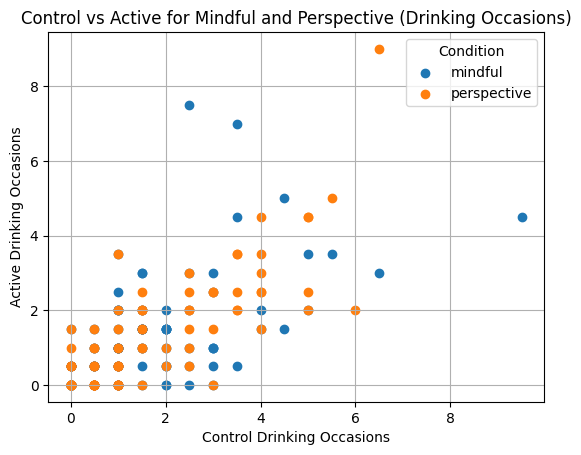

active_week,id,group,condition,active,control
0,muri012,g2p,mindful,0.5,0.5
1,muri015,g2p,perspective,1.0,1.5
2,muri016,g2p,perspective,0.0,0.0
3,muri017,g2p,perspective,0.0,0.0
4,muri018,g2p,perspective,2.5,3.0
5,muri023,g2p,perspective,0.5,2.0
6,muri028,g2p,mindful,0.0,0.0
7,muri034,g2p,perspective,2.0,3.5
8,muri041,g2p,mindful,1.0,1.0
9,muri042,g2p,mindful,0.5,2.0


In [21]:
# Filter for IDs that belong to any condition
filtered_df = aggregated_df[aggregated_df['condition'].isin(['mindful', 'perspective'])]

# Pivot for scatter plot preparation for drinking_occasions
pivot_df_occasions = filtered_df.pivot(index=['id', 'group', 'condition'], columns='active_week', values='drinking_occasions').reset_index()


if plot:
    # Plot scatter for drinking_occasions
    plt.figure()
    for condition in ['mindful', 'perspective']:
        condition_df = pivot_df_occasions[pivot_df_occasions['condition'] == condition]
        plt.scatter(condition_df['control'], condition_df['active'], label=condition)

    plt.xlabel("Control Drinking Occasions")
    plt.ylabel("Active Drinking Occasions")
    plt.title("Control vs Active for Mindful and Perspective (Drinking Occasions)")
    plt.legend(title="Condition")
    plt.grid()
    plt.show()

pivot_df_occasions.head(50)


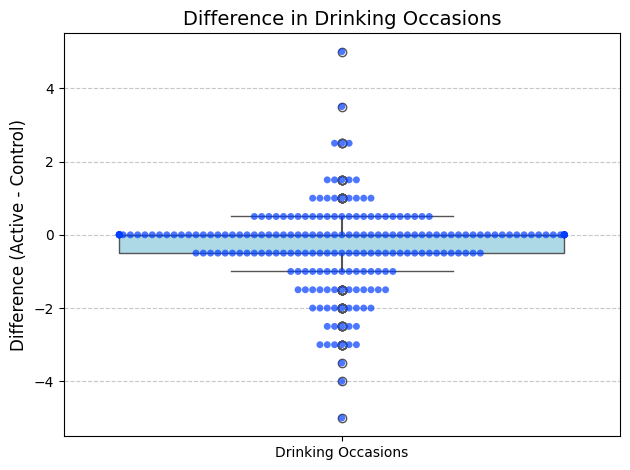

In [22]:
pivot_df_occasions['difference_drinks_occasions'] = pivot_df_occasions['active'] - pivot_df_occasions['control']

pivot_df_occasions['metric'] = 'Drinking Occasions'

if plot:
    # Plot for drinking occasions
    sns.boxplot(
        data=pivot_df_occasions,
        y='difference_drinks_occasions',
        x='metric',
        showcaps=True,
        boxprops={'facecolor': 'lightblue'},  # Add color to the box
        whiskerprops={'linewidth': 1.5},
        palette='muted'  # Use a colorful palette
    )
    sns.swarmplot(
        data=pivot_df_occasions,
        y='difference_drinks_occasions',
        x='metric',
        palette='bright',  # Use a colorful palette for swarm points
        alpha=0.7
    )
    plt.title("Difference in Drinking Occasions", fontsize=14)
    plt.ylabel("Difference (Active - Control)", fontsize=12)
    plt.xlabel("", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


### Calculate responsiveness

In [23]:
# use pre-defined threshold to define who is and is not responsive
pivot_df_occasions['responsive'] = (pivot_df_occasions['difference_drinks_occasions'] < def_response_drink_occasions).astype(int)

pivot_df_occasions.head(2)


active_week,id,group,condition,active,control,difference_drinks_occasions,metric,responsive
0,muri012,g2p,mindful,0.5,0.5,0.0,Drinking Occasions,0
1,muri015,g2p,perspective,1.0,1.5,-0.5,Drinking Occasions,0


In [24]:
responsive_ids_occasions = pivot_df_occasions[pivot_df_occasions['responsive'] == 1]['id'].nunique()

print(f"Total sample size: {pivot_df_occasions['id'].nunique()}")
print(f'Responsive (drinking occasions): {responsive_ids_occasions}')

Total sample size: 218
Responsive (drinking occasions): 14


In [25]:
responsiveness_df = pivot_df_occasions
responsiveness_df.drop_duplicates(subset=['id'])
len(responsiveness_df)

218

In [26]:
responsiveness_df.drop(columns=['metric'], inplace=True)
responsiveness_df.to_csv(os.path.join('../../SHINE/final_buckets', 'responsive_users_standard.csv'), index=False)

# Get unique participant IDs for each study
ids_study1 = set(data_study1['id'].unique())
ids_study2 = set(data_study2['id'].unique())

# Subset the main DataFrame
df_study1 = responsiveness_df[responsiveness_df['id'].isin(ids_study1)]
df_study2 = responsiveness_df[responsiveness_df['id'].isin(ids_study2)]

print(len(df_study1))
print(len(df_study2))

# Save the files
df_study1.to_csv(os.path.join('../../SHINE/final_buckets', f'responsiveness_study1_{def_response_drink_occasions}.csv'), index=False)
df_study2.to_csv(os.path.join('../../SHINE/final_buckets', 'responsiveness_study2.csv'), index=False)


71
147


# Merge Baseline Data (Buckets)

In [27]:
exclude_cols = [
    'Unnamed: 0', 'pID', 'X.1', 'X', 'Alcohol_Size_None_sum',
       'Alcohol_Size_One_sum', 'Alcohol_Size_Small_sum',
       'Alcohol_Size_Large_sum''Condition', 'SHINEID', 
       'Alc_Encounter_sum', 
       'Craving_Alc_mean', 
       'Converse_Alc_sum', 
       'Alc_Converse_Valence_mean', 
       'NegativeMood_mean'
       ]

In [28]:
COMMON_VARS = [
    'id', 'group', 'condition', 'active',
    'control', 'difference_drinks_occasions',
    'metric', 'responsive'] 

# common vars and vars including alcohol encounter data need to be excluded from training data in all cases
EXCLUDE_VARS = COMMON_VARS + exclude_cols

In [29]:
responsiveness_df.head()

active_week,id,group,condition,active,control,difference_drinks_occasions,responsive
0,muri012,g2p,mindful,0.5,0.5,0.0,0
1,muri015,g2p,perspective,1.0,1.5,-0.5,0
2,muri016,g2p,perspective,0.0,0.0,0.0,0
3,muri017,g2p,perspective,0.0,0.0,0.0,0
4,muri018,g2p,perspective,2.5,3.0,-0.5,0


In [30]:
print(b4_brain.columns)
print(responsiveness_df.columns)


Index(['id', 'ROI_alc_react_v_rest_neurosynth_cogcontrol',
       'ROI_alc_react_v_rest_neurosynth_craving',
       'ROI_alc_react_v_rest_neurosynth_emoreg',
       'ROI_alc_react_v_rest_neurosynth_reward',
       'segregation_resting_state_total', 'reward', 'mentalizing',
       'ROI_alc_react_v_rest_VS'],
      dtype='object')
Index(['id', 'group', 'condition', 'active', 'control',
       'difference_drinks_occasions', 'responsive'],
      dtype='object', name='active_week')


In [31]:
len(b1_alcohol_self.columns) + len(b2_group_subjective.columns) + len(b3_group_sociometric.columns) + len(b4_brain.columns) + len(b5_demographic.columns) + len(b6_psychometric.columns)

67

In [32]:
len(responsiveness_df)

218

In [33]:
# b1_alcohol_self = pd.read_csv('../../SHINE/b1_alcohol_self.csv', index_col=0)
# b2_group_subjective = pd.read_csv('../../SHINE/b2_group_subjective_new.csv', index_col=0)
# b3_group_sociometric= pd.read_csv('../../SHINE/b3_group_sociometric.csv', index_col=0)
# b4_brain= pd.read_csv('../../SHINE/b4_brain.csv', index_col=0)


b1_alcohol_self_response = pd.merge(b1_alcohol_self, responsiveness_df, on='id', how='inner')
b2_group_subjective_response = pd.merge(b2_group_subjective, responsiveness_df, on='id', how='inner')
b2_group_subjective_response_old = pd.merge(b2_group_subjective_old, responsiveness_df, on='id', how='inner')
b3_group_sociometric_response = pd.merge(b3_group_sociometric, responsiveness_df, on='id', how='inner')
b4_brain_response = pd.merge(b4_brain, responsiveness_df, on='id', how='inner')
b5_demographic_response = pd.merge(b5_demographic, responsiveness_df, on='id', how='inner')
b6_psychometric_response = pd.merge(b6_psychometric, responsiveness_df, on='id', how='inner')
b2_group_subjective_test = pd.merge(b2_group_subjective_test, responsiveness_df, on='id', how='inner')
b2_group_subjective_test_study1 = pd.merge(b2_group_subjective_test_study1, responsiveness_df, on='id', how='inner')

print(f'Total IDs: {len(b1_alcohol_self_response)}')
print(f'Responsive IDs: {b1_alcohol_self_response[b1_alcohol_self_response["responsive"] == 1]["id"].nunique()}')
print(f'---------------')
print(f'Responsive & Mindful: {b1_alcohol_self_response[(b1_alcohol_self_response["responsive"] == 1) & (b1_alcohol_self_response["condition"] == "mindful")]["id"].nunique()}')
print(f'Responsive & Perspective: {b1_alcohol_self_response[(b1_alcohol_self_response["responsive"] == 1) & (b1_alcohol_self_response["condition"] == "perspective")]["id"].nunique()}')

Total IDs: 69
Responsive IDs: 6
---------------
Responsive & Mindful: 3
Responsive & Perspective: 3


In [34]:
len(b2_group_subjective_test)
b2_group_subjective_test.columns

Index(['id', 'avg_alcmost_freq', 'avg_alcmost', 'alc_norm_5_r', 'groupAtt_alc',
       'groupAtt_binge', 'group', 'condition', 'active', 'control',
       'difference_drinks_occasions', 'responsive'],
      dtype='object')

In [35]:
dataframes = {
    'alc_self': b1_alcohol_self_response,
    'group_sub': b2_group_subjective_response,
    'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response,
    'demo': b5_demographic_response,
    'psych': b6_psychometric_response
}

for key, df in dataframes.items():
    print(f"Missing values in '{key}':")
    print(df.isna().sum())
    print()  # for spacing between outputs

Missing values in 'alc_self':
id                                 0
alc_binge_efficacy                 0
alc_intent_binge                   0
DMQ_drinking_coping_motive         0
DMQ_drinking_enhancement_motive    0
DMQ_drinking_social_motive         0
DMQ_drinking_conformity_motive     0
AUQ_drink_intent                   0
AUQ_drink_frequency                0
AUQ_drink_amount                   0
alcohol_alc_att_1                  0
alcohol_alc_att_2                  0
DEQ_reduced_tension_exp            2
DEQ_increased_confidence_exp       2
DEQ_negative_consequences_exp      2
DEQ_reduced_cognition_exp          2
DEQ_increased_sexual_exp           2
group                              0
condition                          0
active                             0
control                            0
difference_drinks_occasions        0
responsive                         0
dtype: int64

Missing values in 'group_sub':
id                             0
avg_alcmost_freq               0
avg_alcm

## Handle NaN

### Alcohol Self

In [36]:
print(f'Samples: {len(b1_alcohol_self_response)}')
print(f'Responsive Num Occasions: {b1_alcohol_self_response[b1_alcohol_self_response["responsive"] == 1]["id"].nunique()}')

b1_alcohol_self_response.head()
b1_alcohol_self_response.drop(columns=['group', 'condition', 'active', 'control', 'difference_drinks_occasions', 'metric', 'responsive']).to_csv('data_demo.csv', index=False)


Samples: 69
Responsive Num Occasions: 6


KeyError: "['metric'] not found in axis"

In [ ]:
b1_alcohol_self_response.isna().sum()

### Group Subjective

In [ ]:
b2_group_subjective_response.isna().sum()



In [ ]:
b2_group_subjective_response_old.isna().sum()


In [ ]:
b2_group_subjective_response.fillna(0)
print(f'Samples: {len(b2_group_subjective_response)}')
print(f'Responsive Num Occasions: {b2_group_subjective_response[b2_group_subjective_response["responsive"] == 1]["id"].nunique()}')

b2_group_subjective_response[['groupAtt_alc', 'groupAtt_binge']] = b2_group_subjective_response[['groupAtt_alc', 'groupAtt_binge']].astype(int)

b2_group_subjective_response.head()
# b2_group_subjective_response.drop(columns=['group', 'condition', 'active', 'control', 'difference_drinks_occasions', 'metric', 'responsive']).to_csv('data_demo.csv', index=False)



### Group Sociometric

In [ ]:
b3_group_sociometric_response.isna().sum()

In [ ]:
# print(bucket_response_psych.isna().sum()[bucket_response_psych.isna().sum() > 0])
b3_group_sociometric_response = b3_group_sociometric_response.fillna(0)

len(b3_group_sociometric_response)

# Median imputation for NA values is handled in prepare_features_and_targets

### Brain

In [ ]:
b4_brain_response

In [ ]:
b4_brain_response.isna().sum()

In [ ]:
print(f'Samples: {len(b4_brain_response)}')
print(f'Responsive Num Occasions: {b4_brain_response[b4_brain_response["responsive"] == 1]["id"].nunique()}')

len(b4_brain_response.columns)
# b4_brain_response.drop(columns=['group', 'condition', 'active', 'control', 'difference_drinks_occasions', 'metric', 'responsive']).to_csv('data_brain.csv', index=False)


# Feature Selection

## Find highly correlated features within buckets
Find redundancy in features if they are highly correlated

In [ ]:
dataframes = {
    'alc_self': b1_alcohol_self_response,
    'group_sub': b2_group_subjective_response,
    'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response,
    'demo': b5_demographic_response,
    'psych': b6_psychometric_response
}

In [ ]:
b2_group_subjective_response.columns

In [ ]:
def find_highly_correlated_features(dataframes, threshold=0.8):
    """
    Identifies pairs of highly correlated features in each dataframe.
    :param dataframes: dict of {name: dataframe}
    :param threshold: correlation threshold to consider as "high"
    :return: dict of {name: list of correlated feature pairs}
    """
    correlated_features = {}
    for name, df in dataframes.items():
        # Exclude COMMON_VARS from the correlation computation
        columns_to_correlate = [col for col in df.columns if col not in COMMON_VARS]
        
        # Compute correlation matrix only for selected columns
        corr_matrix = df[columns_to_correlate].corr().abs()
        
        # Select the upper triangle of the correlation matrix
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        # Find pairs of features with correlation above the threshold
        correlated_pairs = [
            (col, idx, upper_triangle.loc[idx, col])
            for col in upper_triangle.columns
            for idx in upper_triangle.index
            if upper_triangle.loc[idx, col] > threshold
        ]
        
        # Store results for the current dataframe
        correlated_features[name] = correlated_pairs

    return correlated_features

In [ ]:
correlated_features = find_highly_correlated_features(dataframes, threshold=0.8)

# Display results
for name, pairs in correlated_features.items():
    print(f"\n{name} - Highly Correlated Features:")
    for col1, col2, corr_value in pairs:
        print(f"  {col1} ↔ {col2} : Correlation = {corr_value:.2f}")


Remove highly correlated features:

In [ ]:
dataframes['brain'].drop(columns=['reward', 'ROI_alc_react_v_rest_neurosynth_cogcontrol', 'ROI_alc_react_v_rest_neurosynth_craving', \
                                  'ROI_alc_react_v_rest_neurosynth_emoreg'], inplace=True)

dataframes['group_socio'].drop(columns=['leaders_deg_in', 'goToBad_deg_in'], inplace=True)

dataframes['psych'].drop(columns=['ACS_focus', 'DERS_strategies', 'BIS_attention_total'], inplace=True)

In [ ]:
correlated_features = find_highly_correlated_features(dataframes, threshold=0.8)

# Display results
for name, pairs in correlated_features.items():
    print(f"\n{name} - Highly Correlated Features:")
    for col1, col2, corr_value in pairs:
        print(f"  {col1} ↔ {col2} : Correlation = {corr_value:.2f}")


In [ ]:
# number of features
{key: df.shape[1] for key, df in dataframes.items()}

## Sample Descriptions

In [ ]:
dataframes = {
    'alc_self': b1_alcohol_self_response,
    'group_sub': b2_group_subjective_response,
    'group_sub_old': b2_group_subjective_response_old,
    'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response,
    'demo': b5_demographic_response,
    'psych': b6_psychometric_response
}

target_var = 'responsive'

In [ ]:
b5_demographic_response

## Significance tests: Features
### Mann-Whitney U Tests

Hypothesis test for non-normally distributed data to check which of the remaining features show the most (significant) difference between the two groups (responsive vs non-responsive)

In [ ]:
target_var = 'responsive'

In [ ]:
dataframes = {
    'alc_self': b1_alcohol_self_response,
    'group_sub': b2_group_subjective_response,
    'group_sub_old': b2_group_subjective_response_old,
    'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response,
    'demo': b5_demographic_response,
    'psych': b6_psychometric_response
}

In [ ]:
b2_group_subjective_response.head()

In [ ]:
def perform_mann_whitney_u(df, target_var, exclude_vars):
    results = {}
    for col in df.columns:
        if col not in exclude_vars and col != target_var:
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                group1 = df[df[target_var] == 0][col]
                group2 = df[df[target_var] == 1][col]
                stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                results[col] = {'U_statistic': stat, 'p_value': p_value}
            except Exception as e:
                results[col] = {'error': str(e)}
    return results

In [ ]:
mwu_results = {}
for name, df in dataframes.items():
    if name != 'demo' and target_var in df.columns:
        mwu_results[name] = perform_mann_whitney_u(df, target_var, EXCLUDE_VARS)

# Output summary
for name, results in mwu_results.items():
    print(f"\n{name} DataFrame Mann-Whitney U Test Results (p-value < 0.05):")
    
    # Ensure only variables with p-values < 0.05 are retained
    significant_results = {}
    for var, stats in results.items():
        if isinstance(stats, dict) and 'p_value' in stats and stats['p_value'] < 0.05:
            significant_results[var] = stats  
    
    if significant_results:
        df_significant = pd.DataFrame(significant_results).T  
        print(df_significant)
    else:
        print("No significant results (p-value < 0.05) found.")

    print("---------------")


# ML Models

## Train / Test Splits

In [ ]:

def prepare_features_and_targets(df, target_var, test_set=0, resampling=None):
    if target_var not in df.columns:
        raise ValueError(f"Target variable '{target_var}' not found in dataframe.")

    # Extract target variable and drop excluded columns
    targets = df[target_var]
    features = df[[col for col in df.columns if col not in EXCLUDE_VARS]]
    features = features.drop(columns=[target_var], errors='ignore')

    # Split into training and test sets (STRATIFIED)
    if test_set:
        X_train, X_test, Y_train, Y_test = train_test_split(
            features, targets, test_size=test_set, stratify=targets
        )
    else: 
        X_train = features
        Y_train = targets
        X_test = []
        Y_test = []

    # Median imputation for 'income_numeric' if it contains NA values
    if 'income_numeric' in X_train.columns:
        if X_train['income_numeric'].isna().any():
            X_train['income_numeric'].fillna(X_train['income_numeric'].median(), inplace=True)
        if isinstance(X_test, pd.DataFrame) and 'income_numeric' in X_test.columns and X_test['income_numeric'].isna().any():
            X_test['income_numeric'].fillna(X_test['income_numeric'].median(), inplace=True)

    if 'IAS_mean' in X_train.columns:
        if X_train['IAS_mean'].isna().any():
            X_train['IAS_mean'].fillna(X_train['IAS_mean'].median(), inplace=True)
        if isinstance(X_test, pd.DataFrame) and 'IAS_mean' in X_test.columns and X_test['IAS_mean'].isna().any():
            X_test['IAS_mean'].fillna(X_test['IAS_mean'].median(), inplace=True)

    return X_train, Y_train, X_test, Y_test

## Random Forest

In [ ]:
def random_forest_kfold_grid_search(
    X, Y, param_grid, k=5, CV_reps=1, eval_metric=['auc'], model_choice_metric='auc', 
    res_dir=".", model_type='rf', combo='alcohol'
):

    # Generate all parameter combinations
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    # Initialize variables to store the best model and scores
    best_model = None
    best_scores = None
    best_params = None
    best_model_choice_value = -np.inf  # Track the best model based on the chosen metric

    kf = StratifiedKFold(n_splits=k, shuffle=True)

    for params in param_combinations:
        current_params = dict(zip(param_names, params))

        # Store all fold results
        all_folds_metrics = {metric: [] for metric in eval_metric}

        for train_index, test_index in kf.split(X, Y):  # k-fold cv split

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

            rep_metrics = {metric: [] for metric in eval_metric}  # Reset for each fold

            for _ in range(CV_reps):  # Repeat that split j times

                # Initialize the model with the current parameters
                if model_type == 'rf':
                    model = RandomForestClassifier(
                        n_estimators=current_params.get("n_estimators", 100),
                        max_depth=current_params.get("max_depth"),
                        min_samples_split=current_params.get("min_samples_split", 2),
                        min_samples_leaf=current_params.get("min_samples_leaf", 1),
                        class_weight="balanced"
                    )
                elif model_type == 'xgb':
                    model = XGBClassifier(
                        n_estimators=current_params.get("n_estimators", 100),
                        max_depth=current_params.get("max_depth", 6),
                        learning_rate=current_params.get("learning_rate", 0.1),
                        min_child_weight=current_params.get("min_child_weight", 1),
                        gamma=current_params.get("gamma", 0),
                        subsample=current_params.get("subsample", 1),
                        colsample_bytree=current_params.get("colsample_bytree", 1),
                        scale_pos_weight=current_params.get("scale_pos_weight", 1),
                        use_label_encoder=False,
                        eval_metric="logloss"
                    )

                model.fit(X_train, Y_train)
                Y_pred = model.predict(X_test)
                Y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

                if 'auc' in eval_metric and Y_prob is not None:
                    rep_metrics['auc'].append(roc_auc_score(Y_test, Y_prob))
                if 'f1' in eval_metric:
                    rep_metrics['f1'].append(f1_score(Y_test, Y_pred))
                if 'accuracy' in eval_metric:
                    rep_metrics['accuracy'].append(accuracy_score(Y_test, Y_pred))
                if 'specificity' in eval_metric or 'sensitivity' in eval_metric:
                    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
                    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
                    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
                    if 'specificity' in eval_metric:
                        rep_metrics['specificity'].append(specificity)
                    if 'sensitivity' in eval_metric:
                        rep_metrics['sensitivity'].append(sensitivity)
                if 'mcc' in eval_metric:
                    rep_metrics['mcc'].append(matthews_corrcoef(Y_test, Y_pred))
                if 'balancedAcc' in eval_metric:
                    rep_metrics['balancedAcc'].append(balanced_accuracy_score(Y_test, Y_pred))
                if 'pr_auc' in eval_metric and Y_prob is not None:
                    precision, recall, _ = precision_recall_curve(Y_test, Y_prob)
                    pr_auc = auc(recall, precision)
                    rep_metrics['pr_auc'].append(pr_auc)

            # Compute median scores per fold and store results
            fold_median_metrics = {metric: np.mean(values) for metric, values in rep_metrics.items()}
            for metric in eval_metric:
                all_folds_metrics[metric].append(fold_median_metrics[metric])

        # Compute final median scores over all folds
        median_rep_metrics = {metric: np.mean(values) for metric, values in all_folds_metrics.items()}

        # Select best model based on median of model_choice_metric
        if median_rep_metrics[model_choice_metric] > best_model_choice_value:
            best_model_choice_value = median_rep_metrics[model_choice_metric]
            best_model = model
            best_params = current_params
            best_scores = median_rep_metrics  # Store median scores for all metrics

    return best_model, best_scores, best_params


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (f1_score, accuracy_score, matthews_corrcoef,
                             balanced_accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc)
from sklearn.model_selection import LeaveOneOut
import numpy as np
from itertools import product

def random_forest_loocv_grid_search(
    X, Y, param_grid, CV_reps=1, eval_metric=['auc'], model_choice_metric='auc', 
    res_dir=".", model_type='rf', combo='alcohol'
):
    
    param_combinations = list(product(*param_grid.values()))
    best_model = None
    best_scores = None
    best_params = None
    best_model_choice_value = -np.inf  # Track the best model based on the chosen metric
    last_trained_model = None  # Fallback model
    
    loo = LeaveOneOut()
    
    for params in param_combinations:
        current_params = dict(zip(param_grid.keys(), params))
        
        all_folds_metrics = {metric: [] for metric in eval_metric}
        
        # Precompute the LOOCV splits once to save time
        splits = list(loo.split(X, Y))
        
        for _ in range(CV_reps):
            all_Y_true = []
            all_Y_prob = []
            all_Y_pred = []
            
            for train_index, test_index in splits:
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
                
                model = RandomForestClassifier(
                    n_estimators=current_params.get("n_estimators", 100),
                    max_depth=current_params.get("max_depth"),
                    min_samples_split=current_params.get("min_samples_split", 2),
                    min_samples_leaf=current_params.get("min_samples_leaf", 1),
                    class_weight="balanced"
                )
                
                model.fit(X_train, Y_train)
                last_trained_model = model  # Store last trained model as fallback
                Y_pred = model.predict(X_test)
                Y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
                
                all_Y_true.append(Y_test.iloc[0])
                all_Y_pred.append(Y_pred[0])
                all_Y_prob.append(Y_prob[0] if Y_prob is not None else Y_pred[0])
            
            fold_metrics = {}
            if 'auc' in eval_metric and len(set(all_Y_true)) > 1:
                fold_metrics['auc'] = roc_auc_score(all_Y_true, all_Y_prob)
            if 'f1' in eval_metric:
                fold_metrics['f1'] = f1_score(all_Y_true, all_Y_pred)
            if 'accuracy' in eval_metric:
                fold_metrics['accuracy'] = accuracy_score(all_Y_true, all_Y_pred)
            if 'mcc' in eval_metric:
                fold_metrics['mcc'] = matthews_corrcoef(all_Y_true, all_Y_pred)
            if 'balancedAcc' in eval_metric:
                fold_metrics['balancedAcc'] = balanced_accuracy_score(all_Y_true, all_Y_pred)
            if 'specificity' in eval_metric or 'sensitivity' in eval_metric:
                tn, fp, fn, tp = confusion_matrix(all_Y_true, all_Y_pred).ravel()
                specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
                if 'specificity' in eval_metric:
                    fold_metrics['specificity'] = specificity
                if 'sensitivity' in eval_metric:
                    fold_metrics['sensitivity'] = sensitivity
            
            for metric in eval_metric:
                all_folds_metrics[metric].append(fold_metrics.get(metric, np.nan))
        
        mean_fold_metrics = {metric: np.mean(values) for metric, values in all_folds_metrics.items()}
        
        if model_choice_metric in mean_fold_metrics and not np.isnan(mean_fold_metrics[model_choice_metric]):
            if mean_fold_metrics[model_choice_metric] > best_model_choice_value:
                best_model_choice_value = mean_fold_metrics[model_choice_metric]
                best_model = model
                best_params = current_params
                best_scores = mean_fold_metrics  
    
    if best_model is None:
        best_model = last_trained_model  # Use last trained model as a fallback
    
    return best_model, best_scores, best_params

In [ ]:
def save_metrics_to_csv(results_dict, results_dir, filename):

    os.makedirs(results_dir, exist_ok=True)


    # Define the output file path
    file_path = os.path.join(results_dir, filename)
    
    # Extract all metric names
    all_metrics = set()
    for metrics in results_dict.values():
        all_metrics.update(metrics.keys())
    
    # Sort metrics for consistency
    all_metrics = sorted(all_metrics)

    # Open CSV file for writing
    with open(file_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        
        # Write header
        header = ["run", "group"] + all_metrics
        writer.writerow(header)

        # Write data
        for group, metrics in results_dict.items():
            num_runs = len(next(iter(metrics.values())))  # Get number of runs from first metric
            for run_idx in range(num_runs):
                row = [run_idx, str(group)]  # Start with run index and group name
                for metric in all_metrics:
                    value = metrics.get(metric, [np.nan] * num_runs)[run_idx]  # Handle missing values
                    row.append(value)
                writer.writerow(row)

In [ ]:
def plot_shap_pdp(model, X, shap_values, feature_names):
    """
    Generates a Partial Dependence Plot (PDP) with SHAP overlay for one feature
    or a PDP interaction plot for two features.

    Args:
        model: Trained Random Forest model.
        X: Test data as a DataFrame.
        shap_values: SHAP values (numpy array).
        feature_names: A single feature (str) or two features (list of two).
    """

    # Ensure features exist
    if isinstance(feature_names, str):
        feature_names = [feature_names]  # Convert to list for consistency

    for feature in feature_names:
        if feature not in X.columns:
            raise ValueError(f"Feature '{feature}' not found in X")

    # Case 1: PDP for a single feature + SHAP overlay
    if len(feature_names) == 1:
        feature_name = feature_names[0]
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Side-by-side comparison

        # PDP Plot
        PartialDependenceDisplay.from_estimator(model, X, [feature_name], ax=axes[0])
        axes[0].set_title(f"PDP for {feature_name}")

        # Get SHAP values for the feature
        feature_index = X.columns.get_loc(feature_name)
        shap_feature_values = shap_values[:, feature_index]

        # Overlay SHAP values on PDP
        axes[0].scatter(X[feature_name], shap_feature_values, color='red', alpha=0.4, label="SHAP values", s=20)
        axes[0].legend()

        # SHAP Dependence Plot
        shap.dependence_plot(feature_name, shap_values, X, ax=axes[1], show=False)
        axes[1].set_title(f"SHAP Dependence Plot for {feature_name}")

        plt.show()

    # Case 2: PDP Interaction Plot for Two Features
    elif len(feature_names) == 2:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # PDP Interaction Plot
        PartialDependenceDisplay.from_estimator(model, X, [feature_names], ax=axes[0])
        axes[0].set_title(f"PDP Interaction: {feature_names[0]} & {feature_names[1]}")

        # SHAP Interaction Dependence Plot
        shap.dependence_plot(feature_names[0], shap_values, X, interaction_index=feature_names[1], ax=axes[1], show=False)
        axes[1].set_title(f"SHAP Interaction Dependence: {feature_names[0]} & {feature_names[1]}")

        plt.show()

    else:
        raise ValueError("Only one or two feature names are supported.")

In [ ]:
shap.initjs()
from sklearn.tree import DecisionTreeClassifier

def run_rf_train_test(dataframes, param_grid, eval_metrics, outer_reps=50, k=5, CV_reps=5, model_choice_metric='f1', 
                      res_dir=f"./results/", model_type='xgb', test_set=0.3, resampling=None, permutation=False):

    timestamp = int(time.time())
    res_dir = f"{res_dir}/{timestamp}_{model_type}_outer{outer_reps}_cvrep{CV_reps}_k{k}_{model_choice_metric}_testsize{test_set}_resampling{resampling}_perm{permutation}/"
    os.makedirs(res_dir, exist_ok=True)
    
    keys = list(dataframes.keys())

    # # Generate cumulative combinations: first, (first+second), (first+second+third), ..., all
    # combinations_keys = [tuple(keys[:i]) for i in range(1, len(keys) + 1)]

    # combo_validation_scores = {}
    # combo_test_scores = {}

    combinations_keys = list(chain.from_iterable(combinations(keys, r) for r in range(1, 3)))
    combo_validation_scores = {}
    combo_test_scores = {}
    best_models = {} 
    best_shap_vals = {}
    best_paramses = {}

    all_val_scores = {}
    all_test_scores = {}
    all_models_sub = []

    for combo in tqdm(combinations_keys):
        validation_scores = {metric: [] for metric in eval_metrics}
        test_scores = {metric: [] for metric in eval_metrics}
        merged_df = dataframes[combo[0]].copy()
        
        for key in combo[1:]:
            merged_df = merged_df.merge(dataframes[key].copy(), how='inner', on=COMMON_VARS)
        if target_var not in merged_df.columns:
            raise ValueError(f"Target variable '{target_var}' not found in merged dataframe for combo: {combo}")
    
        all_shap_values = []
        all_test_data = []
        best_overall_score = -np.inf 
        best_model_for_combo = None
        best_params_for_combo = None
        best_shap_for_combo = None

        for _ in range(outer_reps): # i repetitions of train/test

            # Prepare train/test split for this i (random & stratified)
            X_data, Y_data, X_test, Y_test = prepare_features_and_targets(merged_df.copy(), target_var, test_set=test_set, resampling=resampling)

            if permutation:
                Y_data = Y_data.sample(frac=1, random_state=None).reset_index(drop=True)
                Y_test = Y_test.sample(frac=1, random_state=None).reset_index(drop=True)
                # print(f"after_shuffle: {Y_data.head()}")


            # tree = DecisionTreeClassifier(max_depth=3, random_state=42)
            # tree.fit(X_data, Y_data)  # Train on features (X_data) and target (Y_data)

            # importances = pd.Series(tree.feature_importances_, index=X_data.columns)  # Use X_data.columns
            # print("Feature Importance:", importances.sort_values(ascending=False).head(20))

            if k=='loo':
                best_model, best_scores, best_params = random_forest_loocv_grid_search(X_data, Y_data, 
                                                                                    param_grid, 
                                                                                    CV_reps=CV_reps, 
                                                                                    eval_metric=eval_metrics,
                                                                                    model_choice_metric=model_choice_metric,
                                                                                    res_dir=res_dir,
                                                                                    model_type=model_type,
                                                                                    combo=combo)
            else:

                best_model, best_scores, best_params = random_forest_kfold_grid_search(X_data, Y_data, 
                                                                                    param_grid, k=k, 
                                                                                    CV_reps=CV_reps, 
                                                                                    eval_metric=eval_metrics,
                                                                                    model_choice_metric=model_choice_metric,
                                                                                    res_dir=res_dir,
                                                                                    model_type=model_type,
                                                                                    combo=combo)
            # collect metrics
            for metric, score in best_scores.items():
                validation_scores[metric].append(score)

            # Retrain the best model on the full training dataset and evaluate on the test set
            best_model.fit(X_data, Y_data)
            test_predictions = best_model.predict(X_test)
            proba_predictions = best_model.predict_proba(X_test)[:, 1]

            if model_type == 'rf':  
                explainer = shap.TreeExplainer(best_model)
                shap_values = explainer.shap_values(X_test) 
                shap_values = shap_values[:, :, 1]

            else:
                explainer = shap.TreeExplainer(best_model)
                shap_values = explainer.shap_values(X_test)

            # Append SHAP values and test data for later aggregation
            all_shap_values.append(shap_values)
            all_test_data.append(pd.DataFrame(X_test))

            if best_scores[model_choice_metric] > best_overall_score:
                best_overall_score = best_scores[model_choice_metric]
                best_model_for_combo = best_model
                best_params_for_combo = best_params
                best_shap_for_combo = shap_values  # Store SHAP values if needed

            # Calculate and append metrics for the test set
            test_scores['auc'].append(roc_auc_score(Y_test.ravel(), proba_predictions))
            test_scores['f1'].append(f1_score(Y_test.ravel(), test_predictions))
            test_scores['accuracy'].append(accuracy_score(Y_test.ravel(), test_predictions))

            tn, fp, fn, tp = confusion_matrix(Y_test.ravel(), test_predictions).ravel()
            test_scores['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else np.nan)
            test_scores['sensitivity'].append(tp / (tp + fn) if (tp + fn) > 0 else np.nan)
            test_scores['PPV'].append(tp / (tp + fp) if (tp + fp) > 0 else np.nan)
            test_scores['NPV'].append(tn / (tn + fn) if (tn + fn) > 0 else np.nan)
            test_scores['MCC'].append(matthews_corrcoef(Y_test.ravel(), test_predictions))
            test_scores['balancedAcc'].append(balanced_accuracy_score(Y_test.ravel(), test_predictions))

            precision, recall, _ = precision_recall_curve(Y_test.ravel(), proba_predictions)
            pr_auc = auc(recall, precision)
            test_scores['pr_auc'].append(pr_auc)

            test_scores['tn'].append(tn)
            test_scores['fp'].append(fp)
            test_scores['fn'].append(fn)
            test_scores['tp'].append(tp)

            if combo == ('group_sub',):
                all_models_sub.append(best_model)

        # Keep track of the best model based on the model_choice_metric
        if combo not in best_models or best_scores[model_choice_metric] > combo_validation_scores[combo][model_choice_metric]['mean']:
            best_models[combo] = best_model_for_combo
            best_shap_vals[combo] = best_shap_for_combo
            best_paramses[combo] = best_params_for_combo

        # Combine SHAP values and test data
        final_shap_values = np.vstack(all_shap_values)
        final_test_data = pd.concat(all_test_data, ignore_index=True)

        # Compute relative importance
        mean_abs_shap = np.abs(final_shap_values).mean(axis=0)
        rel_importance = 100 * mean_abs_shap / mean_abs_shap.sum()

        # Plot SHAP summary without showing
        plt.figure()
        shap.summary_plot(final_shap_values, final_test_data, show=False, cmap='winter')

        # Get current axis and y-tick labels
        ax = plt.gca()
        feature_names = [tick.get_text() for tick in ax.get_yticklabels()]

        # Use Index.get_loc instead of list
        col_index = final_test_data.columns
        feature_order = [col_index.get_loc(name) for name in feature_names]

        # Add percentage values
        percent_labels = [f"{name} ({rel_importance[i]:.1f}%)" for name, i in zip(feature_names, feature_order)]
        ax.set_yticklabels(percent_labels, fontsize=10)

        # Save updated plot
        plt.tight_layout()
        plt.savefig(f"{res_dir}/{combo}_shap_summary_plot_with_percentages.png", dpi=300, bbox_inches="tight")
        plt.close()

        # Calculate mean and 95% CI for validation scores
        z = norm.ppf(0.975)  # 95% confidence level
        final_validation_scores = {}
        for metric, scores in validation_scores.items():
            mean_score = np.mean(scores)
            std_error = np.std(scores, ddof=1) / np.sqrt(len(scores))
            ci_lower = mean_score - z * std_error
            ci_upper = mean_score + z * std_error
            final_validation_scores[metric] = {
                'mean': mean_score,
                '95%_CI': (ci_lower, ci_upper)
            }
        combo_validation_scores[combo] = final_validation_scores
        all_val_scores[combo] = validation_scores
        save_metrics_to_csv(all_val_scores, res_dir, 'all_val_scores.csv')

        # Calculate mean and 95% CI for test scores
        final_test_scores = {}
        for metric, scores in test_scores.items():
            mean_score = np.mean(scores)
            std_error = np.std(scores, ddof=1) / np.sqrt(len(scores))
            ci_lower = mean_score - z * std_error
            ci_upper = mean_score + z * std_error
            final_test_scores[metric] = {
                'mean': mean_score,
                '95%_CI': (ci_lower, ci_upper)
            }
        combo_test_scores[combo] = final_test_scores
        all_test_scores[combo] = test_scores
        save_metrics_to_csv(all_test_scores, res_dir, 'all_test_scores.csv')


        rows = []
        # Iterate through the data and flatten it into rows
        for combination, metrics in combo_test_scores.items():
            row = {"Combination": combination}
            for metric, values in metrics.items():
                row[f"{metric}_mean"] = values["mean"]
                row[f"{metric}_CI_lower"] = values["95%_CI"][0]
                row[f"{metric}_CI_upper"] = values["95%_CI"][1]
            rows.append(row)
        df = pd.DataFrame(rows)
        df_comb = pd.DataFrame(df["Combination"].tolist(), columns=[f"Factor_{i+1}" for i in range(df["Combination"].map(len).max())])
        df = pd.concat([df_comb, df.drop(columns="Combination")], axis=1)

        rows = []
        # Iterate through the data and flatten it into rows
        for combination, metrics in combo_validation_scores.items():
            row = {"Combination": combination}
            for metric, values in metrics.items():
                row[f"{metric}_mean"] = values["mean"]
                row[f"{metric}_CI_lower"] = values["95%_CI"][0]
                row[f"{metric}_CI_upper"] = values["95%_CI"][1]
            rows.append(row)
        df = pd.DataFrame(rows)
        df_comb = pd.DataFrame(df["Combination"].tolist(), columns=[f"Factor_{i+1}" for i in range(df["Combination"].map(len).max())])
        df = pd.concat([df_comb, df.drop(columns="Combination")], axis=1)
        df.to_csv(f"{res_dir}/validation_scores.csv")

        rows = []
        # Iterate through the data and flatten it into rows
        for combination, metrics in combo_test_scores.items():
            row = {"Combination": combination}
            for metric, values in metrics.items():
                row[f"{metric}_mean"] = values["mean"]
                row[f"{metric}_CI_lower"] = values["95%_CI"][0]
                row[f"{metric}_CI_upper"] = values["95%_CI"][1]
            rows.append(row)
        df = pd.DataFrame(rows)
        df_comb = pd.DataFrame(df["Combination"].tolist(), columns=[f"Factor_{i+1}" for i in range(df["Combination"].map(len).max())])
        df = pd.concat([df_comb, df.drop(columns="Combination")], axis=1)
        df.to_csv(f"{res_dir}/test_scores.csv")

        
    return combo_validation_scores, combo_test_scores, validation_scores, test_scores, best_models, best_shap_vals, all_shap_values, all_test_data, all_models_sub

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (confusion_matrix, roc_auc_score, f1_score, accuracy_score, 
                             recall_score, precision_score, matthews_corrcoef, balanced_accuracy_score)
from sklearn.inspection import PartialDependenceDisplay

def test_oos(test_df, best_model, best_params, plot=True):
    # Define metrics
    eval_metrics = ['auc', 'f1', 'accuracy', 'specificity', 'sensitivity', 'PPV', 'NPV', 'MCC', 'balancedAcc', 'pr_auc', 'tn', 'fn', 'tp', 'fp']
    
    # Drop common variables
    test_features = test_df.drop(columns=COMMON_VARS + ['responsive'])
    test_labels = test_df['responsive']
    
    # Make predictions
    y_pred_proba = best_model.predict_proba(test_features)[:, 1]  # Probabilities for the positive class
    y_pred = best_model.predict(test_features)
    
    # Compute metrics
    tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
    
    scores = {
        'auc': roc_auc_score(test_labels, y_pred_proba),
        'f1': f1_score(test_labels, y_pred),
        'accuracy': accuracy_score(test_labels, y_pred),
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else np.nan,
        'sensitivity': recall_score(test_labels, y_pred),
        'PPV': precision_score(test_labels, y_pred),
        'NPV': tn / (tn + fn) if (tn + fn) > 0 else np.nan,
        'MCC': matthews_corrcoef(test_labels, y_pred),
        'balancedAcc': balanced_accuracy_score(test_labels, y_pred),
        'pr_auc': roc_auc_score(test_labels, y_pred_proba),
        'tn': tn,
        'fn': fn,
        'tp': tp,
        'fp': fp
    }
    
    colors = ["#22223B", "#4A4E69", "#9A8C98", "#C9ADA7", "#F2E9E4"]

    # SHAP feature importance
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(test_features)
    shap_values = shap_values[:, :, 1]  # Extract SHAP values for positive class
    
    # Compute mean absolute SHAP values for importance ranking
    shap_importance = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame({'feature': test_features.columns, 'importance': shap_importance})
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    
    if plot:
        # Plot SHAP feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importance['importance'], y=feature_importance['feature'], color=colors[1])
        plt.xlabel("Mean Absolute SHAP Value")
        plt.ylabel("Feature")
        plt.title("SHAP Feature Importance")
        plt.show()
        
        # Plot SHAP summary
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, test_features, show=False, cmap='winter')
        plt.show()
        
        # PDP plots as subplots in one figure (including interaction plot)
        top_features = feature_importance['feature'].head(2).tolist()
        num_features = len(test_features.columns) + 1  # +1 for interaction plot
        num_cols = 3  # Number of columns in subplot grid
        num_rows = -(-num_features // num_cols)  # Ceiling division

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
        axes = axes.flatten()  # Flatten axes array for easy iteration

        for idx, feature in enumerate(test_features.columns):
            ax = axes[idx]
            PartialDependenceDisplay.from_estimator(best_model, test_features, [feature], ax=ax, line_kw={"color": colors[1]})
            ax.set_title(f'PDP for {feature}')

        # Add PDP interaction plot in the last subplot
        ax = axes[len(test_features.columns)]
        PartialDependenceDisplay.from_estimator(best_model, test_features, [top_features], ax=ax, line_kw={"color": colors[1]})
        ax.set_title(f'PDP Interaction: {top_features[0]} & {top_features[1]}')

        # Hide unused subplots if any
        for i in range(num_features, len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()
    
    return scores, best_params


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.inspection import PartialDependenceDisplay
from scipy.interpolate import interp1d

def plot_explainability(best_model, all_shap_values, all_test_data):
    """
    Generates:
    - PDP plots with mean & standard deviation for all features, with a histogram below each PDP plot
    - Feature Importance bar plot (SHAP)
    - SHAP Summary plot
    - SHAP Dependence plot for 'avg_alcmost_freq' and 'avg_alcmost'
    - PDP Interaction plot for 'avg_alcmost_freq' and 'avg_alcmost'
    """

    # Define the color palette
    colors = ["#22223B", "#4A4E69", "#9A8C98", "#C9ADA7", "#F2E9E4"]

    # Aggregate SHAP values and test data
    final_shap_values = np.vstack(all_shap_values)
    final_test_data = pd.concat(all_test_data, ignore_index=True)
    
    # Compute SHAP feature importance
    shap_importance = np.abs(final_shap_values).mean(axis=0)
    feature_names = final_test_data.columns
    
    # Sort features by importance
    sorted_indices = np.argsort(shap_importance)[::-1]
    sorted_features = feature_names[sorted_indices]
    sorted_importance = shap_importance[sorted_indices]

    # Determine number of features including interaction plot
    num_features = len(final_test_data.columns)
    num_plots = num_features + 1  # Adding interaction plot
    num_cols = 3  # Set number of columns for subplots
    num_rows = -(-num_plots // num_cols)  # Compute rows (ceiling division)

    # Create figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    axes = axes.flatten()  # Flatten axes array for easy indexing

    # Loop over all features
    for idx, feature_name in enumerate(final_test_data.columns):
        pdp_values = []
        feature_values_list = []

        # Compute PDP for each run and store the results
        for dat in all_test_data:
            ax_dummy = plt.figure().add_subplot()  # Create dummy axis
            ax_dummy.set_visible(False)

            # Generate PDP without displaying it
            pdp_display = PartialDependenceDisplay.from_estimator(best_model, dat, [feature_name], ax=ax_dummy)
            plt.close(ax_dummy.figure)  # Close dummy figure

            # Extract PDP values
            pdp_x = pdp_display.lines_[0][0].get_xdata()
            pdp_y = pdp_display.lines_[0][0].get_ydata()

            pdp_values.append(pdp_y)
            feature_values_list.append(pdp_x)

        # Align all PDP curves to the same feature grid
        common_feature_values = np.linspace(min(map(min, feature_values_list)), 
                                            max(map(max, feature_values_list)), 
                                            num=100)

        interpolated_pdp_values = []
        for i in range(len(pdp_values)):
            f_interp = interp1d(feature_values_list[i], pdp_values[i], kind="linear", fill_value="extrapolate", color=colors[1])
            interpolated_pdp_values.append(f_interp(common_feature_values))

        # Convert to NumPy array for aggregation
        pdp_values = np.array(interpolated_pdp_values)

        # Compute mean and std
        pdp_mean = np.mean(pdp_values, axis=0)
        pdp_std = np.std(pdp_values, axis=0)

        # Plot PDP in subplot
        ax = axes[idx]
        ax.plot(common_feature_values, pdp_mean, label="Mean PDP", color=colors[0], lw=2)
        ax.fill_between(common_feature_values, pdp_mean - pdp_std, pdp_mean + pdp_std, 
                        color=colors[2], alpha=0.5, label="Std Dev")

        # Labels and legend
        ax.set_ylabel("Predicted Value")
        ax.set_title(f"PDP for {feature_name}")
        ax.legend()

    # Plot PDP Interaction for 'avg_alcmost_freq' and 'avg_alcmost'
    ax_interaction = axes[num_features]  # Last subplot
    PartialDependenceDisplay.from_estimator(best_model, final_test_data, 
                                            [("avg_alcmost_freq", "avg_alcmost")], ax=ax_interaction)
    ax_interaction.set_title("Interaction: avg_alcmost_freq & avg_alcmost")

    # Hide unused subplots if any
    for i in range(num_features + 1, len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Feature Importance Bar Plot
    shap.summary_plot(final_shap_values, final_test_data, plot_type="bar", color=colors[1])

    # SHAP Summary Plot
    shap.summary_plot(final_shap_values, final_test_data, cmap='winter')

    # SHAP Dependence Plots
    for feature in ["avg_alcmost_freq", "avg_alcmost"]:
        shap.dependence_plot(feature, final_shap_values, final_test_data)



## Run Analysis

In [ ]:
dataframes = {
    'demo': b5_demographic_response,
    'alc_self': b1_alcohol_self_response,
    'psych': b6_psychometric_response,
    'group_sub': b2_group_subjective_response,
    'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response,
}

# Get sets of unique IDs from each dataframe
id_sets = [set(df["id"].dropna().unique()) for df in dataframes.values()]

# Find intersection of all ID sets
common_ids = set.intersection(*id_sets)
# Step 2: Filter demographic dataframe for those IDs and check who is responsive
responsive_ids = b5_demographic_response[
    (b5_demographic_response["id"].isin(common_ids)) &
    (b5_demographic_response["responsive"] == 1)
]["id"].nunique()

print(f"Number of responsive IDs present in all dataframes: {responsive_ids}")

# Print result
print(f"Number of unique IDs present in all dataframes: {len(common_ids)}")


In [ ]:
b4_brain_response.columns

In [ ]:
param_grid = {
    "n_estimators": [50],
    "max_depth": [3, 5],
    "min_samples_split": [2, 4, 8],
    "min_samples_leaf": [2, 3, 5]
}

eval_metrics = ['auc', 'f1', 'accuracy', 'specificity', 'sensitivity', 'PPV', 'NPV', 'MCC', 'balancedAcc', 'pr_auc', 'tn', 'fn', 'tp', 'fp']

permutation_tests = True

#### 2-fold CV

##### Normal Run

In [ ]:
# combo_validation_scores, combo_test_scores, all_val_scores, all_test_scores, best_model_k2, best_params_k2, all_shap_values_k2, all_test_data_k2 = run_rf_train_test(dataframes, 
#                                                                                                 param_grid, 
#                                                                                                 eval_metrics, 
#                                                                                                 outer_reps=100,
#                                                                                                 k=2, 
#                                                                                                 CV_reps=5, 
#                                                                                                 model_choice_metric='auc', 
#                                                                                                 res_dir=f"./results_finalbuckets/", 
#                                                                                                 model_type='rf', 
#                                                                                                 test_set=0.3, 
#                                                                                                 resampling=None,
#                                                                                                 permutation=False)

In [ ]:
# scores, best_params = test_oos(b2_group_subjective_test, best_model_k2[('group_sub',)], best_model_k2[('group_sub',)])
# scores

##### Permutation Test

In [ ]:
# if permutation_tests:
#     combo_validation_scores, combo_test_scores, all_val_scores, all_test_scores, best_model, best_params, all_shap_values, all_test_data = run_rf_train_test(dataframes, 
#                                                                                                 param_grid, 
#                                                                                                 eval_metrics, 
#                                                                                                 outer_reps=100, 
#                                                                                                 k=2, 
#                                                                                                 CV_reps=5, 
#                                                                                                 model_choice_metric='auc', 
#                                                                                                 res_dir=f"./results_finalbuckets/", 
#                                                                                                 model_type='rf', 
#                                                                                                 test_set=0.3, 
#                                                                                                 resampling=None,
#                                                                                                 permutation=True)

#### 3-fold CV

##### Normal Run

In [ ]:
# dataframes = {
#     'group_sub': b2_group_subjective_response,
# }

dataframes = {
    'demo': b5_demographic_response,
    'alc_self': b1_alcohol_self_response,
    'psych': b6_psychometric_response,
    'group_sub': b2_group_subjective_response,
    'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response,
}

combo_validation_scores, combo_test_scores, all_val_scores, all_test_scores, best_model_k3, best_shaps_k3, all_shap_values_k3, all_test_data_k3 = run_rf_train_test(dataframes, 
                                                                                                param_grid, 
                                                                                                eval_metrics, 
                                                                                                outer_reps=100, 
                                                                                                k=3, 
                                                                                                CV_reps=5, 
                                                                                                model_choice_metric='auc', 
                                                                                                res_dir=f"./results_finalbuckets/", 
                                                                                                model_type='rf', 
                                                                                                test_set=0.3, 
                                                                                                resampling=None,
                                                                                                permutation=True)

In [ ]:
# dataframes = {
#     'group_sub': b2_group_subjective_response,
# }

dataframes = {
    # 'demo': b5_demographic_response,
    # 'alc_self': b1_alcohol_self_response,
    # 'psych': b6_psychometric_response,
    'group_sub': b2_group_subjective_response,
    # 'group_socio': b3_group_sociometric_response,
    # 'brain': b4_brain_response,
}

combo_validation_scores, combo_test_scores, all_val_scores, all_test_scores, best_model_k3, best_shaps_k3, all_shap_values_k3, all_test_data_k3, \
    all_models_sub = run_rf_train_test(dataframes, 
                                                                                                param_grid, 
                                                                                                eval_metrics, 
                                                                                                outer_reps=100, 
                                                                                                k=3, 
                                                                                                CV_reps=5, 
                                                                                                model_choice_metric='auc', 
                                                                                                res_dir=f"./results_finalbuckets/", 
                                                                                                model_type='rf', 
                                                                                                test_set=0.3, 
                                                                                                resampling=None,
                                                                                                permutation=False)

In [ ]:
all_models_sub

In [ ]:
combo_test_scores

In [ ]:
# Plot SHAP/Feat importance for the full train/validation data

# plot_explainability(best_model_k3[('group_sub',)], all_shap_values_k3, all_test_data_k3)

In [ ]:
# Feature importance and SHAP summary for the best model and its validation set

colors = ["#22223B", "#4A4E69", "#9A8C98", "#C9ADA7", "#F2E9E4"]

# Extract SHAP values, model, and test data
shap_values_dict, model_dict, all_test_data_k3 = best_shaps_k3, best_model_k3, all_test_data_k3

# Extract key (e.g., 'group_sub') and associated SHAP values and model
key = list(shap_values_dict.keys())[0]
shap_values = shap_values_dict[key]  # SHAP values
model = model_dict[key]  # RandomForest model

# Ensure all_test_data_k3 is a DataFrame (if it's a list, extract first element)
if isinstance(all_test_data_k3, list):
    all_test_data_k3 = all_test_data_k3[0]  # Extract DataFrame

# Extract feature names
feature_names = all_test_data_k3.columns.to_numpy()

# Extract actual feature dataset (X_test) for SHAP summary plot
X_test = all_test_data_k3.to_numpy()  # Convert DataFrame to numpy array if needed

# Compute feature importance from the Random Forest model
feature_importance = model.feature_importances_

# Ensure alignment between feature names and importances
sorted_indices = np.argsort(feature_importance)
feature_importance_sorted = feature_importance[sorted_indices]
feature_names_sorted = feature_names[sorted_indices]

# Plot Feature Importance (Random Forest)
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance_sorted, y=feature_names_sorted, color=colors[1])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

# Convert SHAP values to array (if not already)
shap_values_array = np.array(shap_values)

# SHAP Summary Plot WITH Feature Values
shap.summary_plot(shap_values_array, X_test, feature_names=feature_names, cmap='winter')



In [ ]:
# Histograms for distribution of the GRP features

# Define color scheme
colors = ["#22223B", "#4A4E69", "#9A8C98", "#C9ADA7", "#F2E9E4"]

# Define features and bin settings
features = {
    "avg_alcmost_freq": (range(0, 110, 10), colors[2]),  # 1-100, bins of 10
    "avg_alcmost": (np.arange(0, 22.5, 1), colors[2]),  # 1-20, bins of 2.5
    "alc_norm_5_r": (range(1, 7, 1), colors[2]),  # 1-5, bins of 1
    "groupAtt_alc": (range(1, 7, 1), colors[2]),  # 1-5, bins of 1
    "groupAtt_binge": (range(1, 7, 1), colors[2]),  # 1-5, bins of 1
}

# Determine the number of features
num_features = len(features)
num_cols = 2  # Set to two columns
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate required rows

# Create histograms
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))
axes = axes.flatten()

for i, (feature, (bins, color)) in enumerate(features.items()):
    axes[i].hist(b2_group_subjective_response[feature].dropna(), bins=bins, color=color, edgecolor=colors[1])
    axes[i].set_title(feature)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Out-of sample testing

scores, best_params = test_oos(b2_group_subjective_test, best_model_k3[('group_sub',)], best_model_k3[('group_sub',)])
scores

In [ ]:
len(b2_group_subjective_test)
b2_group_subjective_test.describe()

In [ ]:
b2_group_subjective.describe()

In [ ]:
# Repeat resample / stratification of the test
import scipy.stats as st

b2_group_subjective_test.dropna()
# Define number of iterations
n_iterations = 100
desired_positive_rate = 0.24  # Ensure 23% positive class

# Separate positive and negative cases once
positive_cases = b2_group_subjective_test[b2_group_subjective_test['responsive'] == 1]
negative_cases = b2_group_subjective_test[b2_group_subjective_test['responsive'] == 0]

# Store results
all_scores = []

for _ in range(n_iterations):
    # Recalculate the target positive count each iteration
    total_samples = len(b2_group_subjective_test)  # Keep dataset size unchanged
    target_positive_count = int(total_samples * desired_positive_rate)
    target_negative_count = total_samples - target_positive_count  # Adjust negatives

    # Resample positives and negatives
    positive_resampled = resample(positive_cases, replace=True, n_samples=target_positive_count, random_state=None)
    negative_resampled = resample(negative_cases, replace=False, n_samples=target_negative_count, random_state=None)

    # Create balanced dataset
    balanced_df = pd.concat([positive_resampled, negative_resampled])
    balanced_df = balanced_df.sample(frac=1, random_state=None).reset_index(drop=True)

    # Run the model and store scores
    scores, best_params = test_oos(balanced_df, best_model_k3[('group_sub',)], [], plot=False)
    print(balanced_df.responsive.sum() / len(balanced_df))
    all_scores.append(scores)

# Convert to DataFrame
scores_df = pd.DataFrame(all_scores)

# Compute mean and 95% CI for each metric
mean_scores = scores_df.mean()
ci_lower, ci_upper = st.t.interval(0.95, df=n_iterations-1, loc=mean_scores, scale=scores_df.sem())

# Combine into a DataFrame for better visualization
summary_df = pd.DataFrame({'Mean': mean_scores, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

summary_df


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.utils import resample
from tqdm import tqdm

# Load and filter for group_sub
df = pd.read_csv("/Users/fmagdalena/Documents/GitHub/shine-network-analysis/src/responsiveness/results_finalbuckets/1744295312_rf_outer100_cvrep5_k3_auc_testsize0.3_resamplingNone_permFalse/all_test_scores.csv")
group_name = "('group_sub',)"
group_df = df[df['group'] == group_name]

# Select top 10 models based on AUC
top_indices = group_df['auc'].nlargest(5).index.tolist()
top_models_sub = [all_models_sub[i] for i in top_indices]

# Prepare test set
b2_group_subjective_test = b2_group_subjective_test.dropna()

# Define number of iterations and target positive rate
n_iterations = 50
desired_positive_rate = 0.24

# Pre-separate positive and negative cases
positive_cases = b2_group_subjective_test[b2_group_subjective_test['responsive'] == 1]
negative_cases = b2_group_subjective_test[b2_group_subjective_test['responsive'] == 0]

# Store all scores
all_scores = []

# Loop over each top model and perform resampling/testing
for model in tqdm(top_models_sub, desc="Running top models"):
    for _ in range(n_iterations):
        # Stratified sampling
        total_samples = len(b2_group_subjective_test)
        target_positive_count = int(total_samples * desired_positive_rate)
        target_negative_count = total_samples - target_positive_count

        positive_resampled = resample(positive_cases, replace=True, n_samples=target_positive_count, random_state=None)
        negative_resampled = resample(negative_cases, replace=False, n_samples=target_negative_count, random_state=None)

        balanced_df = pd.concat([positive_resampled, negative_resampled])
        balanced_df = balanced_df.sample(frac=1, random_state=None).reset_index(drop=True)

        # Test model
        scores, _ = test_oos(balanced_df, model, [], plot=False)
        all_scores.append(scores)

# Convert to DataFrame
scores_df = pd.DataFrame(all_scores)

# Compute mean and 95% CI
mean_scores = scores_df.mean()
ci_lower, ci_upper = st.t.interval(0.95, df=len(scores_df)-1, loc=mean_scores, scale=scores_df.sem())

# Create summary
summary_df = pd.DataFrame({'Mean': mean_scores, '95% CI Lower': ci_lower, '95% CI Upper': ci_upper})

summary_df


##### Permutation Test

In [ ]:
if permutation_tests:
    combo_validation_scores, combo_test_scores, all_val_scores, all_test_scores, best_model, best_params, all_shap_values, all_test_data = run_rf_train_test(dataframes, 
                                                                                                param_grid, 
                                                                                                eval_metrics, 
                                                                                                outer_reps=100, 
                                                                                                k=3, 
                                                                                                CV_reps=5, 
                                                                                                model_choice_metric='auc', 
                                                                                                res_dir=f"./results_finalbuckets/", 
                                                                                                model_type='rf', 
                                                                                                test_set=0.3, 
                                                                                                resampling=None,
                                                                                                permutation=True)

#### 5-fold CV

##### Normal Run

In [ ]:
combo_validation_scores, combo_test_scores, all_val_scores, all_test_scores, best_model_k5, best_params_k5, all_shap_values_k5, all_test_data_k5 = run_rf_train_test(dataframes, 
                                                                                                param_grid, 
                                                                                                eval_metrics, 
                                                                                                outer_reps=100, 
                                                                                                k=5, 
                                                                                                CV_reps=5, 
                                                                                                model_choice_metric='auc', 
                                                                                                res_dir=f"./results_finalbuckets/", 
                                                                                                model_type='rf', 
                                                                                                test_set=0.3, 
                                                                                                resampling=None,
                                                                                                permutation=False)

In [ ]:
# scores, best_params = test_oos(b2_group_subjective_test, best_model[('group_sub',)], best_model[('group_sub',)])
# scores

##### Permutation Test

In [ ]:
if permutation_tests:
    combo_validation_scores, combo_test_scores, all_val_scores, all_test_scores, best_model, best_params, all_shap_values, all_test_data = run_rf_train_test(dataframes, 
                                                                                                param_grid, 
                                                                                                eval_metrics, 
                                                                                                outer_reps=50, 
                                                                                                k=5, 
                                                                                                CV_reps=3, 
                                                                                                model_choice_metric='auc', 
                                                                                                res_dir=f"./results_finalbuckets/", 
                                                                                                model_type='rf', 
                                                                                                test_set=0.3, 
                                                                                                resampling=None,
                                                                                                permutation=True)